# Linear Regression in Julia

File explaining linear regression as seen in class and some other things like normalization. Everything is coded in Julia and proper documentation is written in the .jl script associated with this document.

## Reading of the data

In [2]:
using DelimitedFiles
using Statistics
using LinearAlgebra
using Plots

In [3]:
function data_read(str::String)
    data = readdlm(str, ',', Float64, '\n');
    return data
end

In [4]:
data = data_read("../data/data2.txt");

In [8]:
X = data[:,1:end-1];
y = data[:,end];

## Feature Normalizacion

When diferent features have very different scales of values, sometimes gradient descent can be slower so we can speed up gradient descent by utilizing values in the same range. Ideally we use values such that

$$
-1\le x_{i} \le 1
$$

To do this, while mantaining the same distribution we can use feature scaling and mean normalisation. With this we can mantain the distribution of the values, but the range is only $[-1,1]$.

$$
x_i := \frac{x_i - \mu_i}{\sigma_i}
$$

Where $x_i$ is the vetor with all the values of a feature, $\mu_i$ is the mean values of the feature and $\sigma_i$ is their standard deviation.

In [9]:
function normalization(x::Vector{Float64})
    return (x.-mean(x))/std(x)
end;

In [11]:
X= mapslices(normalization, X; dims = 1);
y = normalization(y);

## Hypothesis Function

Next we define a multivariate form of the hypothesis function:

$$
h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + \dots + \theta_n x_n
$$

Here $\theta_0$ is the bias of the function, $\theta_i$ are weights and $x_i$ are the different parameters to calculate an aproximate $y$ value $\forall i=1,2,3,\dots,n$.
The function can be represented using vector and matrixes as:

$$
h_\theta(x)=
[\theta_0\quad\theta_1\quad\dots\quad\theta_n]
\begin{bmatrix}
	x_1\\
	x_2\\
	\vdots\\
	x_n
\end{bmatrix}
=\theta^T x
$$

Where we assume that $x_0^{(i)}=1$.
Then, we can calculate the hypothesis function as:

$$
h_\theta(X)=X\theta
$$

So, for everything to work we first need to add a column of ones as the first column of the $X$ matrix.

In [12]:
X = [ones(size(X)[1]) X];

In [13]:
θ = rand(size(X)[2],1);

In [14]:
h(θ, X) = (θ * X)[1];

## Cost Function

We can define the cost function as:
$$
E(\theta)=\frac{1}{2m} \sum_{i=1}^m \left(h_\theta(x^{(i)})-y^{(i)} \right)^2
$$
The vectorized verision would be
$$
\begin{align*}
E(\theta)&=\frac{1}{2m} (X\theta -y)^T (X\theta-y)\\
&=\frac{1}{2m} \|X\theta -y\|_2^2
\end{align*}
$$

In [15]:
m = size(X)[1];

In [16]:
E(θ) = norm(X*θ - y, 2)^2/2m;

To be able to modify the values of $\theta$ we need to calculate the derivative of $E(\theta)$. When we calculate the derivative, we can see that

$$
\begin{align*}
&&\frac{\partial E(\theta)}{\partial \theta_j}
    &= \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right) \cdot x_j^{(i)} &&\\
    &&&= \frac{1}{m} \sum_{i=1}^m x_j^{(i)} \cdot \left( h_\theta(x^{(i)}) - y^{(i)} \right) &&\\
    &&&= \frac{1}{m} x_j^{T}  ( X\theta - y ) &&\\
 \implies && \nabla E(\theta) &= \frac{1}{m} X^{T}  ( X\theta - y ) &&\\
\end{align*}
$$

Using this, we can modify the values of $\theta$ using

$$
\theta := \theta - \frac{\alpha}{m} X^T (X\theta -y)
$$

Where $\alpha$ is the learning rate.

In [17]:
∇E(θ) = 1/m * transpose(X) * (X*θ - y);

In [18]:
α = 0.01;

In [19]:
theta_hist = transpose(θ);

Using this, we can see the cost associated with $\theta$.

In [21]:
E(θ)

0.19250318966999655

We can see how the training improves $\theta$ and reduces the cost.
(Normally it should be run until convergence is seen but this here is just an example.)

In [22]:
# Every time we run it, θ is improved. It should be run until convergence
for i in 1:10000
    θ -= α*∇E(θ)
    theta_hist = vcat(theta_hist, transpose(θ))
end
E(θ)

0.13068648053904197

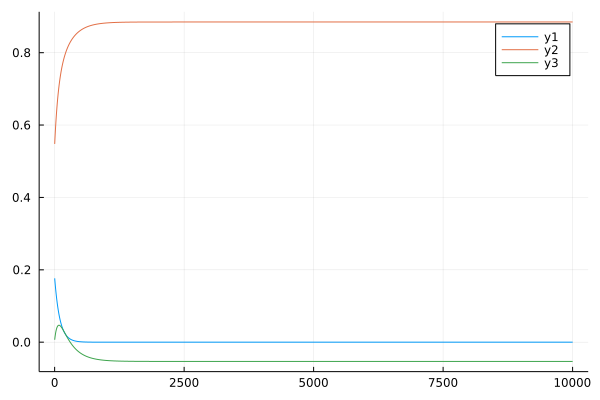

In [24]:
plot(theta_hist) # θ moves to certain values

## Putting everything together

To make it easier to solve a problem and train it, we can put everything together in a structure, so we can normalize the data automatically after reading it and save the values of the mean and std for future predictions. Also we can use this to make comparissons.

In [25]:
mutable struct LR_Problem
    X::Matrix{Float64}       # Normalized data
    y::Vector{Float64}       # Normalized vector
    X_mean::Vector{Float64}  # Means of X matrix per column
    X_std::Vector{Float64}   # STD of X matrix per colum
    y_mean::Float64          # Mean of y
    y_std::Float64           # STD of y
    θ::Matrix{Float64}       # Weights and biases
    θ_hist::Matrix{Float64}
    α::Float64               # Learning rate
    tol::Float64             # Tolerance of error for convergence
    
    function LR_Problem(data::Matrix{Float64}; θ = Matrix{Float64}(undef, 0,0)::Matrix{Float64}, α = 0.01::Float64, tol = 1e-8::Float64)
        means = mapslices(mean, data; dims = 1)
        stds = mapslices(std, data; dims = 1)
        normalized_data = mapslices(normalization, data; dims = 1)
        X = [ones(size(data)[1]) normalized_data[:,1:end-1]]
        y = normalized_data[:,end]
        if size(θ)[2] > 1
            θ = transpose(θ)
        end
        if size(θ)[1] != size(X)[2]
            θ = rand(size(X)[2],1)
        end
        θ_hist = transpose(θ)
        new(X, y, means[1:end-1], stds[1:end-1], means[end], stds[end], θ, θ_hist, α, tol)
    end
end;
    

In [26]:
function compute_cost(prob::LR_Problem)
    m = size(prob.X)[1]
    return norm(prob.X*prob.θ - prob.y, 2)^2/2m
end;

In [27]:
function compute_gradients(prob::LR_Problem)
    m = size(prob.X)[1]
    return 1/m * transpose(prob.X) * (prob.X * prob.θ - prob.y)
end;

In [28]:
function train!(prob::LR_Problem; max_iter  = 100000::Int64)
    iter = 0
    # Train while it has not converged or reach 10000 iterations
    while norm(compute_gradients(prob),2)>prob.tol && iter<=max_iter
        prob.θ -= prob.α * compute_gradients(prob)
        prob.θ_hist = vcat(prob.θ_hist, transpose(prob.θ))
    end
end;

In [ ]:
function predict(prob::LR_Problem, x::Vector{Float64})
    x = (x-prob.X_mean)./prob.X_std # normalize the vector
    x = transpose(vcat(1, x)) # add first column of 1 and transpose
    y = (x * prob.θ)[1] # predict
    y = y * prob.y_std + prob.y_mean # de-normalize
    return y
end;

Having all the previous functions. we can use it to see how the learning rates affect the convergence of the function.

In [217]:
# First we can create various models with different learning rates.
θ = [0 0 0]
learning_rates = [0.001 0.005 0.01 0.05 0.1 0.5 1 1.3 1.5]
problems = [LR_Problem(data, θ = θ, α = α) for α in learning_rates];

In [218]:
train!.(problems);

We can see that all of them converged except the learning rate of 10. This shows that if the learning rate is too large it can diverge instead.

In [219]:
Dict(learning_rates .=> compute_cost.(problems))

Dict{Float64, Float64} with 9 entries:
  1.3   => 0.130686
  0.01  => 0.130686
  0.5   => 0.130686
  0.005 => 0.130686
  1.5   => NaN
  0.1   => 0.130686
  0.001 => 0.130686
  0.05  => 0.130686
  1.0   => 0.130686

In [220]:
function errors_learning(prob::LR_Problem)
    return [norm(prob.X * prob.θ_hist[i,:] - prob.y, 2) for i=1:size(prob.θ_hist)[1]]
end;

 We can see that in this particular problem, the larger learning rates converge more quickly than the smaller learning rates. But if we go a little bigger, like for $\alpha = 1.3$ it is a lot slower, and for $\alpha = 1.5$ it even diverged to it is important to find a good balance between being fast and converging.

In [222]:
Dict(learning_rates .=> sizeof.(errors_learning.(problems)))

Dict{Float64, Int64} with 9 entries:
  1.3   => 9584
  0.01  => 31832
  0.5   => 576
  0.005 => 63720
  1.5   => 22280
  0.1   => 3128
  0.001 => 318840
  0.05  => 6320
  1.0   => 256

We can see that the fastest convergence is with $\alpha = 1$ and it slows down again in $\alpha = 1.3$.

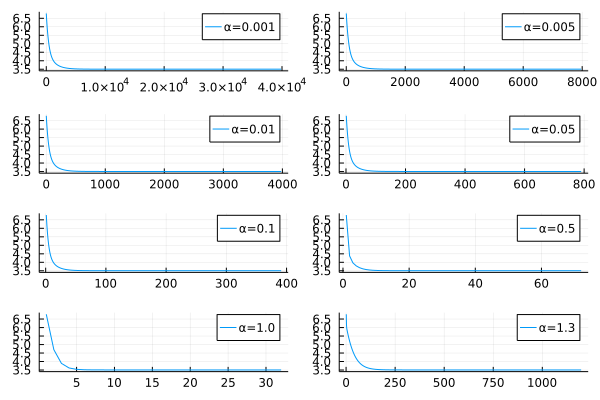

In [223]:
labels = ["α=0.001" "α=0.005" "α=0.01" "α=0.05" "α=0.1" "α=0.5" "α=1.0" "α=1.3"]
plot(errors_learning.(problems[:1:end-1]), layout = (4,2), label = labels)

But when we see $\alpha = 1.5$ we can see how the error grows exponentially.

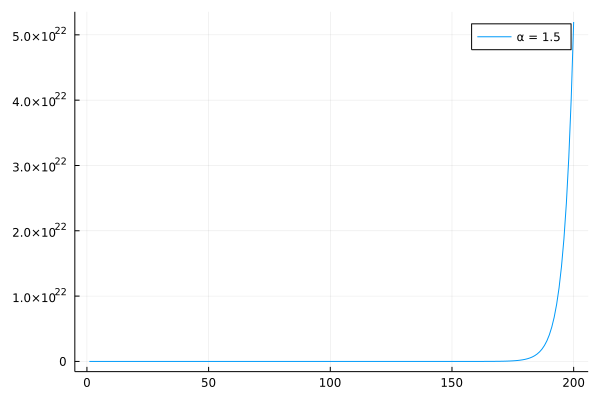

In [227]:
plot(errors_learning(problems[end])[1:200], label = "α = 1.5")

Now we can see how the variables change depending on the learning rate.

We can see that up until $\alpha=0.5$ it goes smoothly. But in $\alpha=1$ the variables are getting smaller and bigger until it converges, so it would be very dangerous to have such a high learning rate because it is not as stable. This is further seen in $\alpha=1.3$.

In [228]:
p1 = plot(problems[1].θ_hist, title = labels[1], labels = ["θ0" "θ1" "θ2"])
p2 = plot(problems[2].θ_hist, title = labels[2], labels = ["θ0" "θ1" "θ2"])
p3 = plot(problems[3].θ_hist, title = labels[3], labels = ["θ0" "θ1" "θ2"])
p4 = plot(problems[4].θ_hist, title = labels[4], labels = ["θ0" "θ1" "θ2"])
p5 = plot(problems[5].θ_hist, title = labels[5], labels = ["θ0" "θ1" "θ2"])
p6 = plot(problems[6].θ_hist, title = labels[6], labels = ["θ0" "θ1" "θ2"])
p7 = plot(problems[7].θ_hist, title = labels[7], labels = ["θ0" "θ1" "θ2"])
p8 = plot(problems[8].θ_hist, title = labels[8], labels = ["θ0" "θ1" "θ2"])
plot(p1,p2,p3,p4,p5,p6,p7,p8, layout =(4,2))

In [229]:
problems[9].θ_hist[1:10,:]

10×3 Matrix{Float64}:
  0.0           0.0        0.0
 -1.25493e-16   1.25519    0.649277
 -3.02123e-16   0.133899  -0.68651
  2.51378e-16   1.75688    0.860546
 -6.17391e-16  -0.274614  -1.19783
  6.13722e-16   2.36845    1.43572
 -1.05197e-15  -1.03372   -1.96981
  1.19136e-15   3.35841    2.42111
 -1.82194e-15  -2.30717   -3.24489
  2.11495e-15   5.0027     4.06484

Here it can be seen how the variables jump back and forth with each jump getting bigger. This is why it diverges, because each iteration the absolute value of the variable will grow exponentially and it will approach infinity.

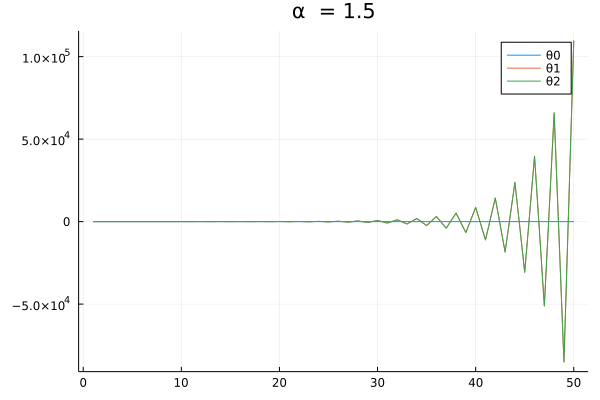

In [238]:
plot(problems[9].θ_hist[1:50,:], title = "α  = 1.5", labels = ["θ0" "θ1" "θ2"])